In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

RANDOM_STATE = 37

In [260]:
df = pd.read_csv("drug200.csv")
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


Датасет содержит данные о пациентах, имевших одинаковое заболевание. Однако от этого забоелвания разным пациентам помогло разное лекарство (Drug A, B, C, X, Y). Интересно уметь предсказывать, какое из этих лекарств поможет в лечении заболевания в зависимости от данных пациента.

Признаки:

- Age -- Patient Age
- Sex -- Gender of patient
- BP -- Levels of blood pressure
- Cholesterol -- Levels of cholesterol
- Na_to_K -- Sodium to potassium ratio in blood
- Drug -- Type of drug (целевой признак)

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Датасет не содержит нулевых значений.

In [262]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

Рассмотрим распределение целевого признака. Классы (лекарства) распределены неравномерно: пациентам из датасета чаще всего помогало лекарство DrugY.

##EDA

<Axes: xlabel='Drug', ylabel='count'>

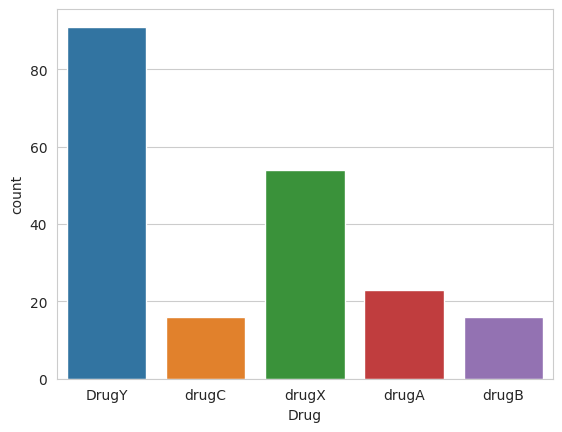

In [263]:
sns.countplot(x=df['Drug'])

Пациентов-женщин и пациентов-мужчин примерно поровну.

<Axes: xlabel='Sex', ylabel='count'>

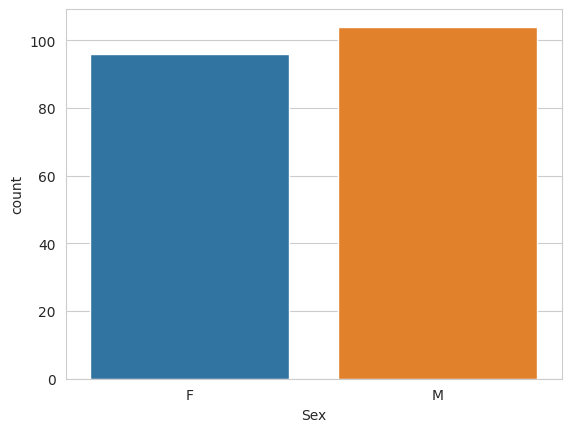

In [264]:
sns.countplot(data=df, x='Sex')

Рассмотрим распределения количественных признаков.

<Axes: xlabel='Age', ylabel='Density'>

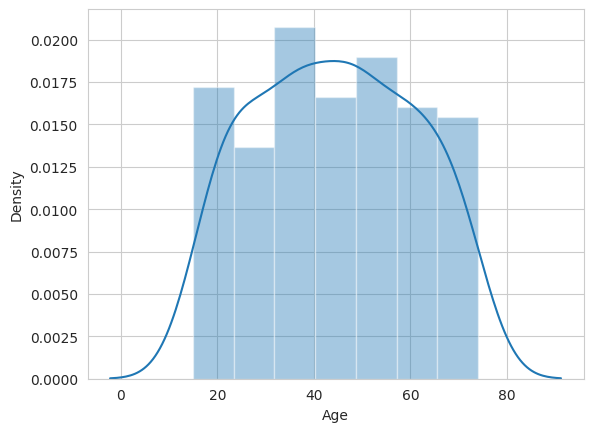

In [265]:
sns.distplot(df['Age'])

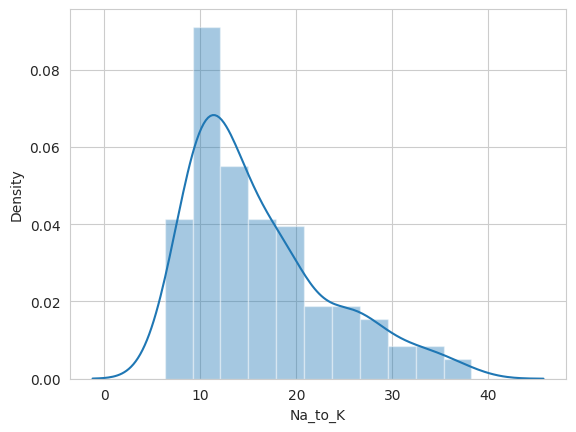

In [266]:
sns.distplot(df['Na_to_K']);

Чаще всего встречаются пациенты с повышенным давлением.

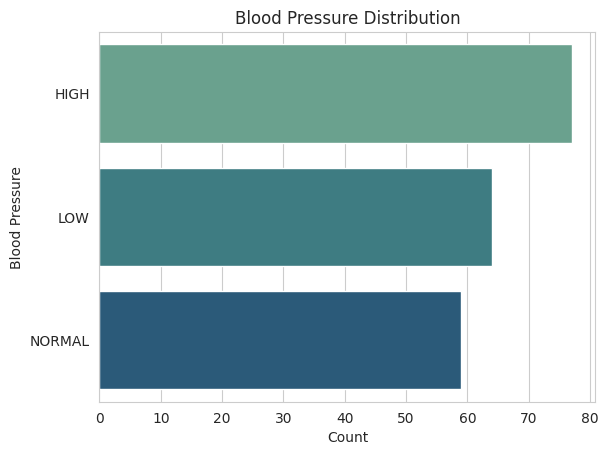

In [267]:
sns.countplot(y=df['BP'], data=df , palette="crest")
plt.ylabel('Blood Pressure')
plt.xlabel('Count')
plt.title('Blood Pressure Distribution');

Интересно, что DrugB чаще всего оказывался эффективным у пожилых пациентов.

Text(0.5, 1.0, 'Age vs Drug')

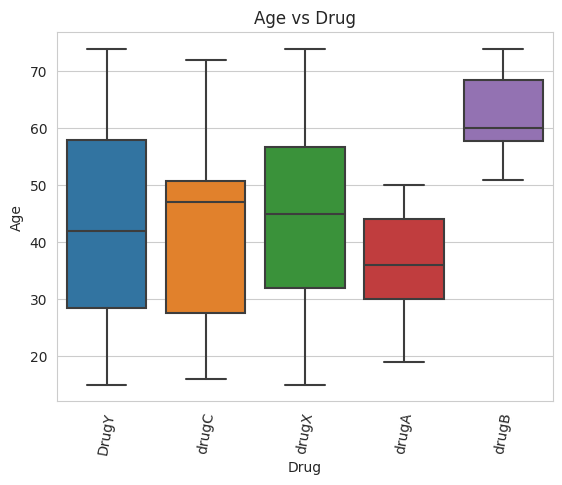

In [268]:
sns.boxplot(data=df, x="Drug", y="Age")
plt.xticks(rotation=80)
plt.xlabel("Drug")
plt.ylabel("Age")
plt.title("Age vs Drug")

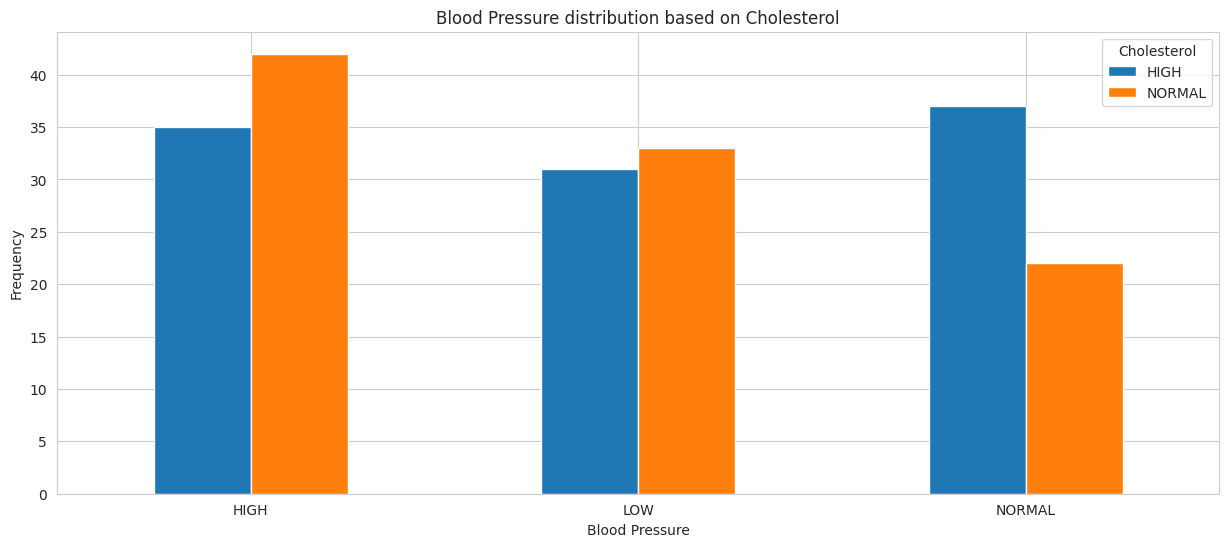

In [269]:
pd.crosstab(df.BP,df.Cholesterol).plot(kind="bar",figsize=(15,6))#,color=['#6929c4','#1192e8'])
plt.title('Blood Pressure distribution based on Cholesterol')
plt.xlabel('Blood Pressure')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

Отметим, что количественные признаки практически не коррелируют между собой.

<Axes: >

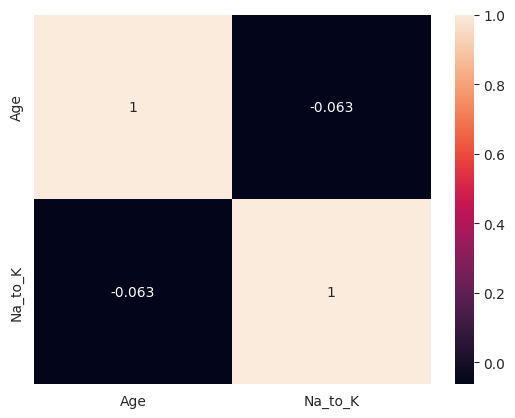

In [270]:
sns.heatmap(df.corr(), annot=True)

Преобразуем данные и обучим модели.

In [271]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

X = df.drop('Drug' , axis='columns')
X = pd.get_dummies(X, drop_first=True)
y = df['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [272]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), param_grid=param_grid, cv=5, scoring="roc_auc_ovr", error_score="raise")
searcher = searcher.fit(X_train_scaled, y_train)

best_logreg_params = searcher.best_params_
print("Best params =", best_logreg_params)

Best params = {'C': 1000.0}


In [273]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=RANDOM_STATE, probability=True), param_grid=param_grid, cv=5)
searcher = searcher.fit(X_train_scaled, y_train)

best_svc_params = searcher.best_params_
print("Best params: ", best_svc_params)

Best params:  {'C': 0.25, 'gamma': 'scale', 'kernel': 'linear'}


In [274]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring="roc_auc_ovr", error_score="raise")
searcher = searcher.fit(X_train_scaled, y_train)

best_knn_params = searcher.best_params_
print("Best params =", str(best_knn_params))

Best params = {'n_neighbors': 13, 'weights': 'distance'}


In [275]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"var_smoothing": np.logspace(0, -10, num=100)}]

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=5, scoring="roc_auc_ovr", error_score="raise")
searcher = searcher.fit(X_train_scaled, y_train)

best_gnb_params = searcher.best_params_
print("Best params =", str(best_gnb_params))

Best params = {'var_smoothing': 0.019179102616724886}


In [276]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [2, 5, 10],
               "max_features": [2, 5, 10]}]

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid, cv=5, scoring="roc_auc_ovr", error_score="raise")
searcher = searcher.fit(X_train_scaled, y_train)

best_dt_params = searcher.best_params_
print("Best params =", str(best_dt_params))

Best params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}


In [277]:
from sklearn.model_selection import cross_validate

def measure_fit_time(model, X, y):
    return cross_validate(model, X, y, cv=5)["fit_time"].mean()

accuracies = {}
times = {}

##OneVsRest

In [278]:
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

ovr_logreg = OneVsRestClassifier(LogisticRegression(**best_logreg_params, random_state=RANDOM_STATE)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovr_logreg.predict(X_test_scaled))
fit_time = measure_fit_time(ovr_logreg, X_train_scaled, y_train)

accuracies["OVR_Logreg"] = accuracy
times["OVR_Logreg"] = fit_time

print(f"OVR_Logreg accuracy {accuracy}")
print(f"OVR_Logreg time {fit_time}")

OVR_Logreg accuracy 0.9166666666666666
OVR_Logreg time 0.030806207656860353


In [279]:
ovr_svm = OneVsRestClassifier(SVC(**best_svc_params, random_state=RANDOM_STATE, probability=True)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovr_svm.predict(X_test_scaled))
fit_time = measure_fit_time(ovr_svm, X_train_scaled, y_train)

accuracies["OVR_SVM"] = accuracy
times["OVR_SVM"] = fit_time

print(f"OVR_SVM accuracy {accuracy}")
print(f"OVR_SVM time {fit_time}")

OVR_SVM accuracy 0.9166666666666666
OVR_SVM time 0.01431417465209961


In [280]:
ovr_knn = OneVsRestClassifier(KNeighborsClassifier(**best_knn_params)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovr_knn.predict(X_test_scaled))
fit_time = measure_fit_time(ovr_knn, X_train_scaled, y_train)

accuracies["OVR_KNN"] = accuracy
times["OVR_KNN"] = fit_time

print(f"OVR_KNN accuracy {accuracy}")
print(f"OVR_KNN time {fit_time}")


OVR_KNN accuracy 0.9
OVR_KNN time 0.005995416641235351


In [281]:
ovr_nb = OneVsRestClassifier(GaussianNB(**best_gnb_params)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovr_nb.predict(X_test_scaled))
fit_time = measure_fit_time(ovr_nb, X_train_scaled, y_train)

accuracies["OVR_GNB"] = accuracy
times["OVR_GNB"] = fit_time

print(f"OVR_GNB accuracy {accuracy}")
print(f"OVR_GNB time {fit_time}")


OVR_GNB accuracy 0.9
OVR_GNB time 0.007876920700073241


In [282]:
ovr_dt = OneVsRestClassifier(DecisionTreeClassifier(**best_dt_params, random_state=RANDOM_STATE)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovr_dt.predict(X_test_scaled))
fit_time = measure_fit_time(ovr_dt, X_train_scaled, y_train)

accuracies["OVR_DT"] = accuracy
times["OVR_DT"] = fit_time

print(f"OVR_DT accuracy {accuracy}")
print(f"OVR_DT time {fit_time}")

OVR_DT accuracy 0.9666666666666667
OVR_DT time 0.009155368804931641


## OneVsOne

In [283]:
from sklearn.multiclass import OneVsOneClassifier

ovo_logreg = OneVsOneClassifier(LogisticRegression(**best_logreg_params, random_state=RANDOM_STATE)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovo_logreg.predict(X_test_scaled))
fit_time = measure_fit_time(ovo_logreg, X_train_scaled, y_train)

accuracies["OVO_Logreg"] = accuracy
times["OVO_Logreg"] = fit_time

print(f"OVO_Logreg accuracy {accuracy}")
print(f"OVO_Logreg time {fit_time}")


OVO_Logreg accuracy 0.9333333333333333
OVO_Logreg time 0.04344940185546875


In [284]:
ovo_svm = OneVsOneClassifier(SVC(**best_svc_params, random_state=RANDOM_STATE, probability=True)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovo_svm.predict(X_test_scaled))
fit_time = measure_fit_time(ovo_svm, X_train_scaled, y_train)

accuracies["OVO_SVM"] = accuracy
times["OVO_SVM"] = fit_time

print(f"OVO_SVM accuracy {accuracy}")
print(f"OVO_SVM time {fit_time}")


OVO_SVM accuracy 0.9333333333333333
OVO_SVM time 0.019844484329223634


In [285]:
ovo_knn = OneVsOneClassifier(KNeighborsClassifier(**best_knn_params)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovo_knn.predict(X_test_scaled))
fit_time = measure_fit_time(ovo_knn, X_train_scaled, y_train)

accuracies["OVO_KNN"] = accuracy
times["OVO_KNN"] = fit_time

print(f"OVO_KNN accuracy {accuracy}")
print(f"OVO_KNN time {fit_time}")

OVO_KNN accuracy 0.9
OVO_KNN time 0.009630298614501953


In [286]:
ovo_nb = OneVsOneClassifier(GaussianNB(**best_gnb_params)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovo_nb.predict(X_test_scaled))
fit_time = measure_fit_time(ovo_nb, X_train_scaled, y_train)

accuracies["OVO_GNB"] = accuracy
times["OVO_GNB"] = fit_time

print(f"OVO_GNB accuracy {accuracy}")
print(f"OVO_GNB time {fit_time}")

OVO_GNB accuracy 0.85
OVO_GNB time 0.009959983825683593


In [287]:
ovo_dt = OneVsOneClassifier(DecisionTreeClassifier(**best_dt_params, random_state=RANDOM_STATE)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, ovo_dt.predict(X_test_scaled))
fit_time = measure_fit_time(ovo_dt, X_train_scaled, y_train)

accuracies["OVO_DT"] = accuracy
times["OVO_DT"] = fit_time

print(f"OVO_DT accuracy {accuracy}")
print(f"OVO_DT time {fit_time}")


OVO_DT accuracy 0.9833333333333333
OVO_DT time 0.012021684646606445


## OutputCode

In [288]:
from sklearn.multiclass import OutputCodeClassifier

oc_logreg = OutputCodeClassifier(LogisticRegression(**best_logreg_params, random_state=RANDOM_STATE)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, oc_logreg.predict(X_test_scaled))
fit_time = measure_fit_time(oc_logreg, X_train_scaled, y_train)

accuracies["OС_Logreg"] = accuracy
times["OС_Logreg"] = fit_time

print(f"OС_Logreg accuracy {accuracy}")
print(f"OС_Logreg time {fit_time}")

OС_Logreg accuracy 0.9
OС_Logreg time 0.029559850692749023


In [289]:
oc_svm = OutputCodeClassifier(SVC(**best_svc_params, random_state=RANDOM_STATE, probability=True)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, oc_svm.predict(X_test_scaled))
fit_time = measure_fit_time(oc_svm, X_train_scaled, y_train)

accuracies["OC_SVM"] = accuracy
times["OC_SVM"] = fit_time

print(f"OC_SVM accuracy {accuracy}")
print(f"OC_SVM time {fit_time}")


OC_SVM accuracy 0.8166666666666667
OC_SVM time 0.017376422882080078


In [290]:
oc_knn = OutputCodeClassifier(KNeighborsClassifier(**best_knn_params)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, oc_knn.predict(X_test_scaled))
fit_time = measure_fit_time(oc_knn, X_train_scaled, y_train)

accuracies["OC_KNN"] = accuracy
times["OC_KNN"] = fit_time

print(f"OC_KNN accuracy {accuracy}")
print(f"OC_KNN time {fit_time}")


OC_KNN accuracy 0.8333333333333334
OC_KNN time 0.0063514232635498045


In [291]:
oc_nb = OutputCodeClassifier(GaussianNB(**best_gnb_params)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, oc_nb.predict(X_test_scaled))
fit_time = measure_fit_time(oc_nb, X_train_scaled, y_train)

accuracies["OC_GNB"] = accuracy
times["OC_GNB"] = fit_time

print(f"OC_GNB accuracy {accuracy}")
print(f"OC_GNB time {fit_time}")

OC_GNB accuracy 0.7166666666666667
OC_GNB time 0.006188058853149414


In [292]:
oc_dt = OutputCodeClassifier(DecisionTreeClassifier(**best_dt_params, random_state=RANDOM_STATE)).fit(X_train_scaled, y_train)
accuracy = accuracy_score(y_test, oc_dt.predict(X_test_scaled))
fit_time = measure_fit_time(oc_dt, X_train_scaled, y_train)

accuracies["OC_DT"] = accuracy
times["OC_DT"] = fit_time

print(f"OC_DT accuracy {accuracy}")
print(f"OC_DT time {fit_time}")

OC_DT accuracy 0.9833333333333333
OC_DT time 0.009111261367797852


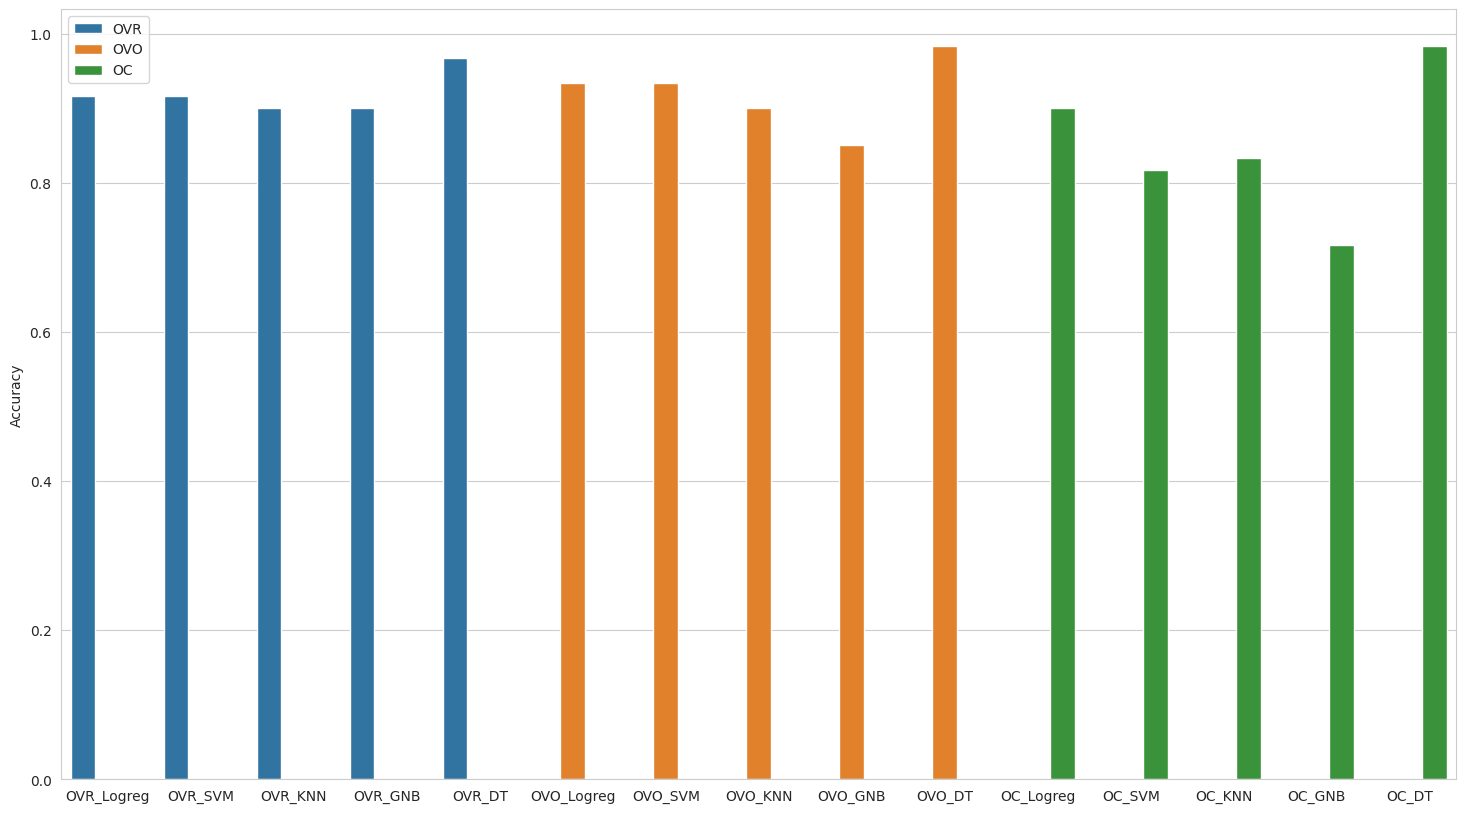

In [293]:
plt.figure(figsize=(18, 10))
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 1.05, 0.05))

colors = ['OVR']*5 + ['OVO']*5 + ['OC']*5
sns.barplot(y=list(accuracies.values()), x=list(accuracies.keys()), hue=colors)
plt.show()

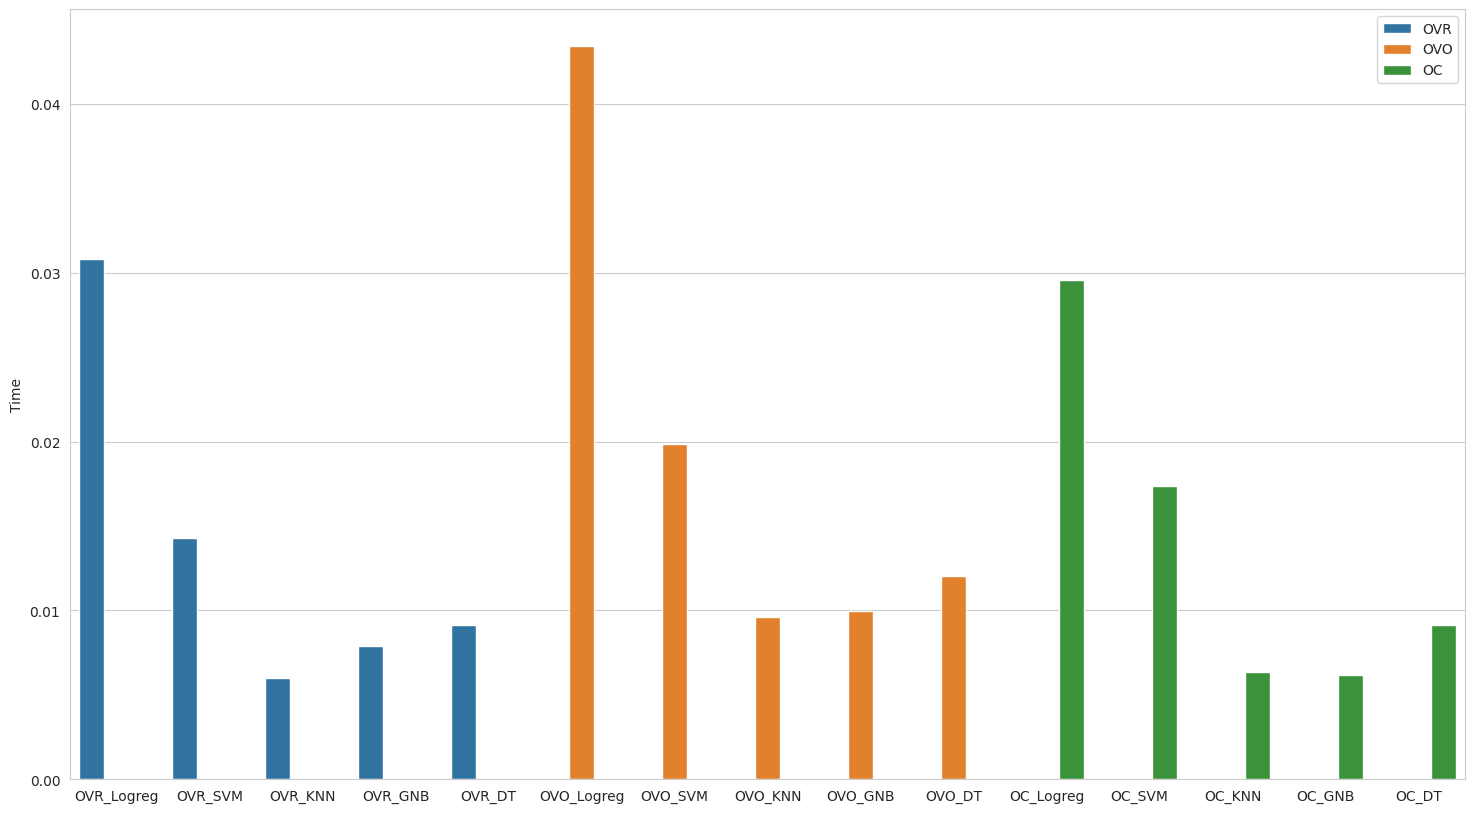

In [294]:
plt.figure(figsize=(18, 10))
plt.ylabel("Time")
plt.xticks(np.arange(0, 1.05, 0.05))

sns.barplot(y=list(times.values()), x=list(times.keys()), hue=colors)
plt.show()

**Вывод**: наибольшую точность для большинства моделей на предложенном датасете показала стратегия OneVsRest. Чуть менее точный (например, с моделью NaiveBayes), но тоже неплохой результат показала OneVsOne. Наименее точной оказалась стратегия OutputCode с моделью SVM. Наиболее медленной при обучениии в сравнении с остальными оказалась стратегия OneVsOne, а самой быстрой на большинстве моделей -- OutputCode. Наиболее быстрый результат показала модель DecisionTree со стратегией OutputCode. Наболее точный результат -- модель DecisionTree со стратегией OneVsOne.

In [295]:
df = pd.read_csv('ENB2012_data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Датасет содержит 12 различных моделей зданий, смоделированных в специальной программе. Здания различаются по площади остекления, распределению площади остекления, ориентации и другим параметрам. Интересно уметь предсказать целевые значения Heating Load и Cooling Load на основе этих параметров.

Признаки:
- Relative Compactness
- Surface Area
- Wall Area
- Roof Area
- Overall Height
- Orientation
- Glazing Area
- Glazing Area Distribution
- Heating Load (целевой признак 1)
- Cooling Load (целевой признак 2)



In [308]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    int64  
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    int64  
 8   heating_load               768 non-null    float64
 9   cooling_load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


Переименуем столбцы, чтобы было удобнее рабоать

In [297]:
df.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height',
                'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

<Axes: xlabel='cooling_load', ylabel='Density'>

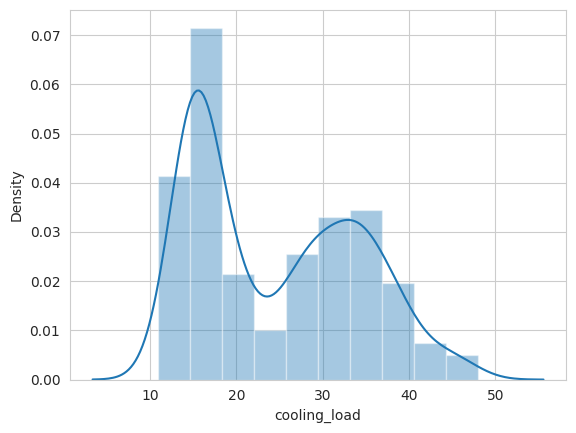

In [298]:
sns.distplot(df["cooling_load"])

<Axes: xlabel='heating_load', ylabel='Density'>

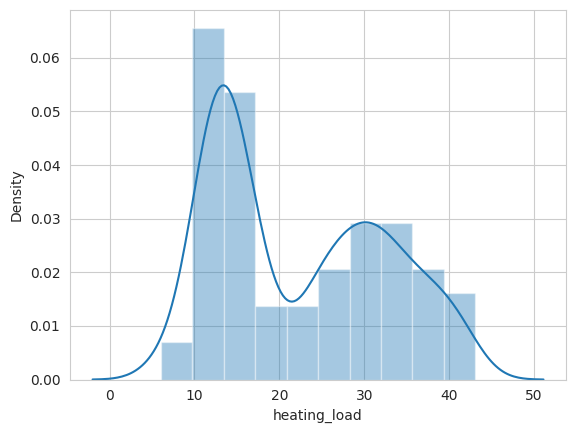

In [299]:
sns.distplot(df["heating_load"])

Посмотрим на распределения признаков:

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

<Figure size 1000x1000 with 0 Axes>

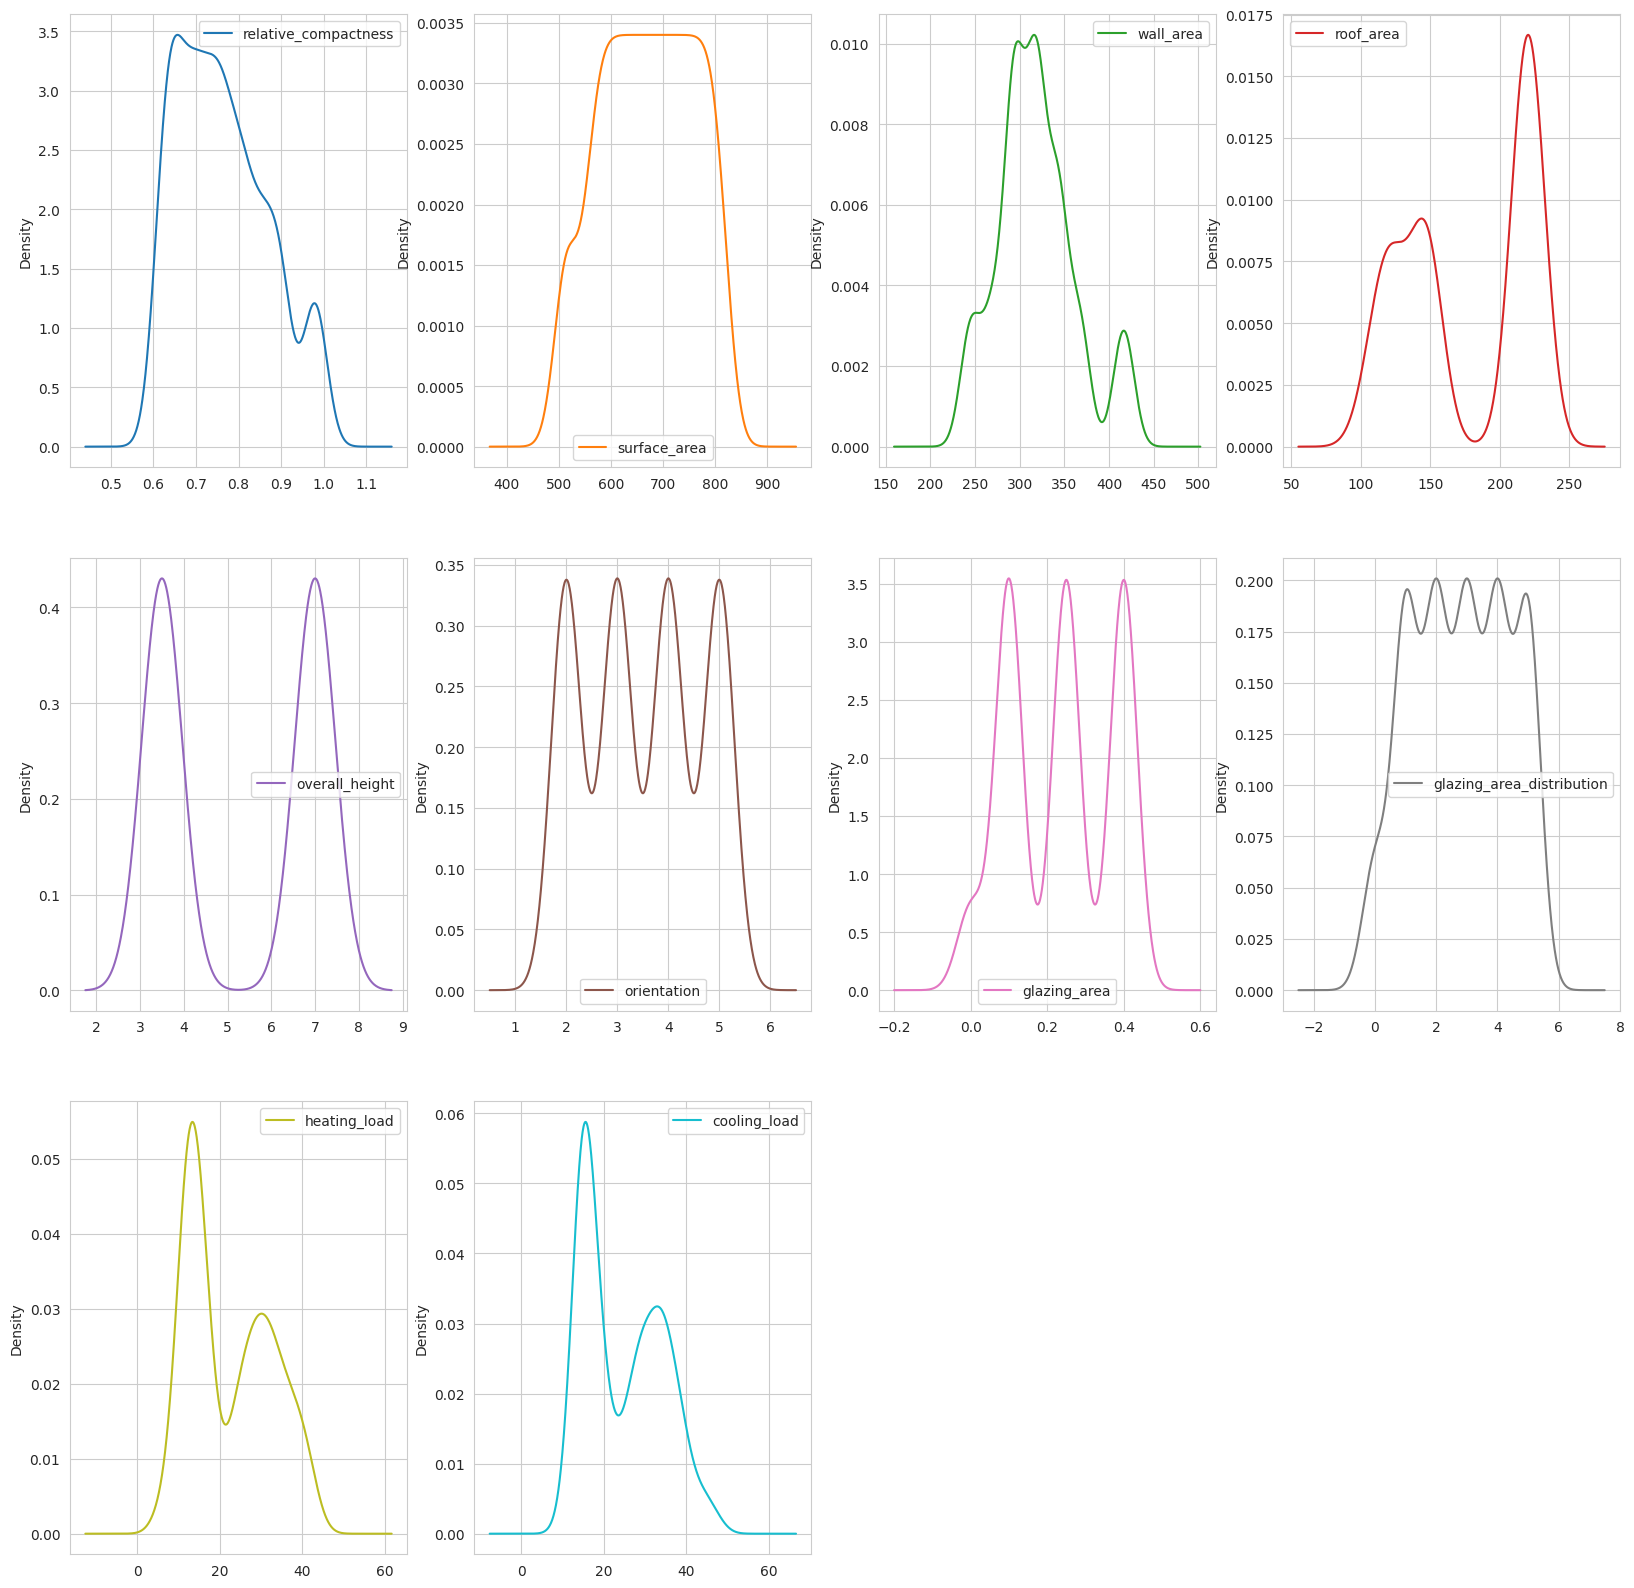

In [300]:
plt.figure(figsize=(10, 10))
df.plot(kind='density', subplots=True, layout=(3,4), sharex=False, sharey=False, figsize=(20, 20))

Рассмотрим матрицу корреляции.

<Axes: >

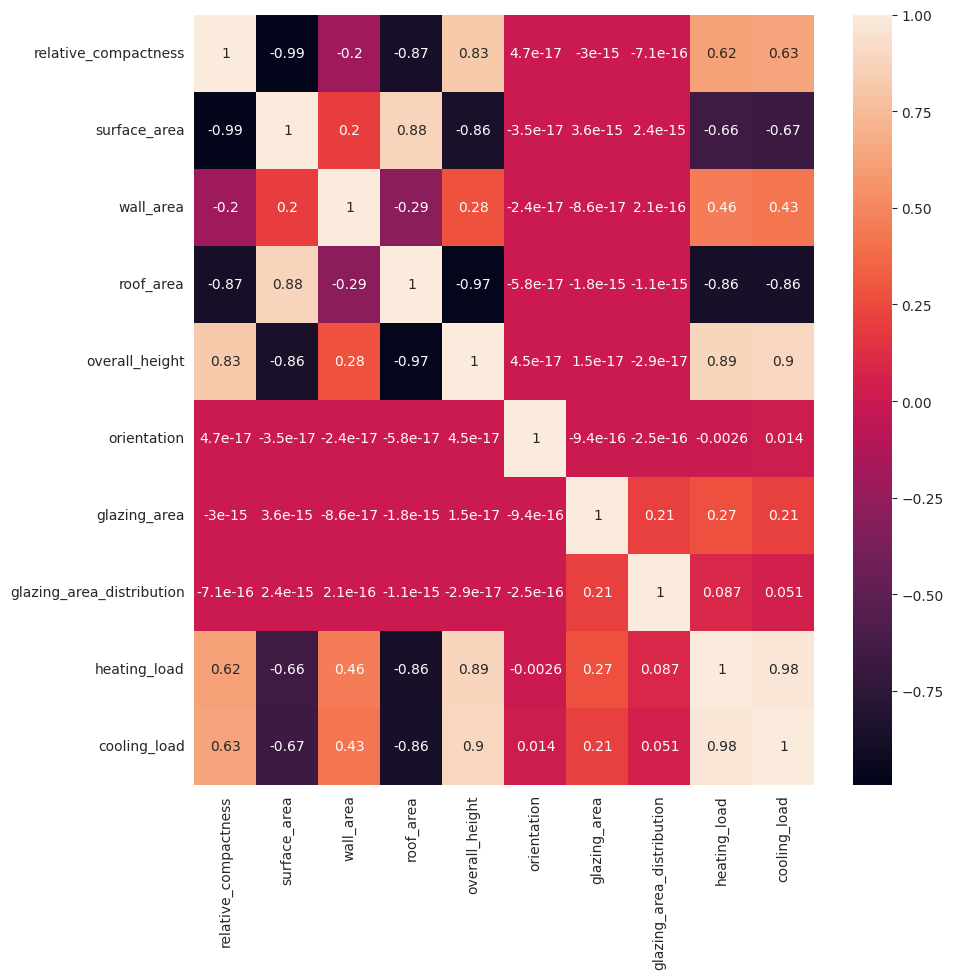

In [301]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(),annot=True)

Стоит отметить, что целевые признаки (heating_load и cooling_load) имеют довольно сильную корреляцию.

Разобъём датасет на тествую и обучающую выборку, произведём масштабирование и обучим модели.

In [302]:
y = df[['heating_load','cooling_load']]
X = df.drop(['heating_load','cooling_load'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

accuracies = {}
times = {}

In [303]:
from sklearn.linear_model import Ridge

param_grid = {"alpha": np.logspace(-5, 3, 20)}

searcher = GridSearchCV(Ridge(), param_grid, scoring="r2", cv=5)
searcher.fit(X_train_scaled, y_train)

best_ridge_params = searcher.best_params_

In [304]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import r2_score

mor_ridge = MultiOutputRegressor(Ridge(**best_ridge_params))
mor_ridge.fit(X_train_scaled, y_train)
y_pred = mor_ridge.predict(X_test_scaled)
fit_time = measure_fit_time(mor_ridge, X_train_scaled, y_train)
r2 = r2_score(y_test, y_pred)
accuracies["MOR_Ridge"] = r2
times["MOR_Ridge"] = fit_time
print(f"MOR_Ridge R^2 {r2}")
print(f"MOR_Ridge time {fit_time}")

MOR_Ridge R^2 0.9004400267429269
MOR_Ridge time 0.004993534088134766


In [305]:
rc_ridge = RegressorChain(Ridge(**best_ridge_params))
rc_ridge.fit(X_train_scaled, y_train)
y_pred = rc_ridge.predict(X_test_scaled)
fit_time = measure_fit_time(rc_ridge, X_train_scaled, y_train)
r2 = r2_score(y_test, y_pred)
accuracies["RC_Ridge"] = r2
times["RC_Ridge"] = fit_time
print(f"RC_Ridge R^2 {r2}")
print(f"RC_Ridge time {fit_time}")

RC_Ridge R^2 0.9004400267429269
RC_Ridge time 0.00509791374206543


Сравним точность полученных моделей. Результаты обеих стратегий примерно одинаковы.

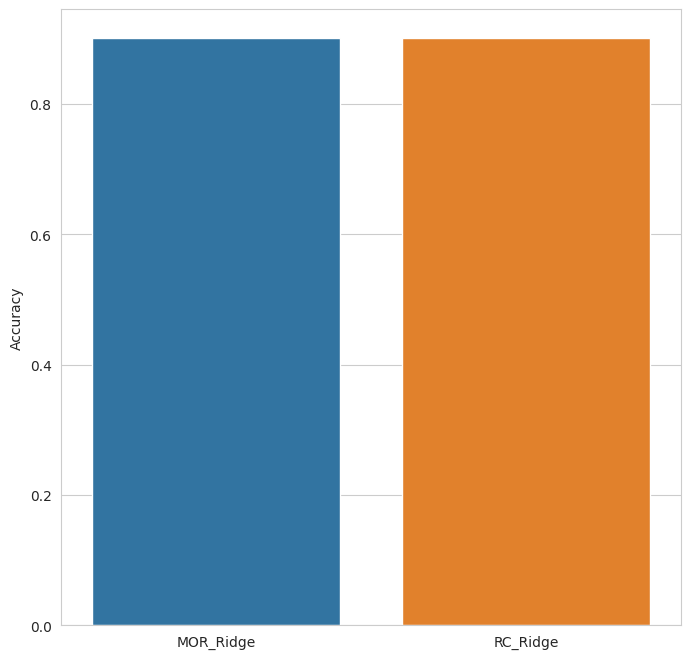

In [306]:
plt.figure(figsize=(8, 8))
plt.ylabel("Accuracy")

sns.barplot(y=list(accuracies.values()), x=list(accuracies.keys()))
plt.show()

Однако MultiOutputRegressor обучается несколько быстрее.

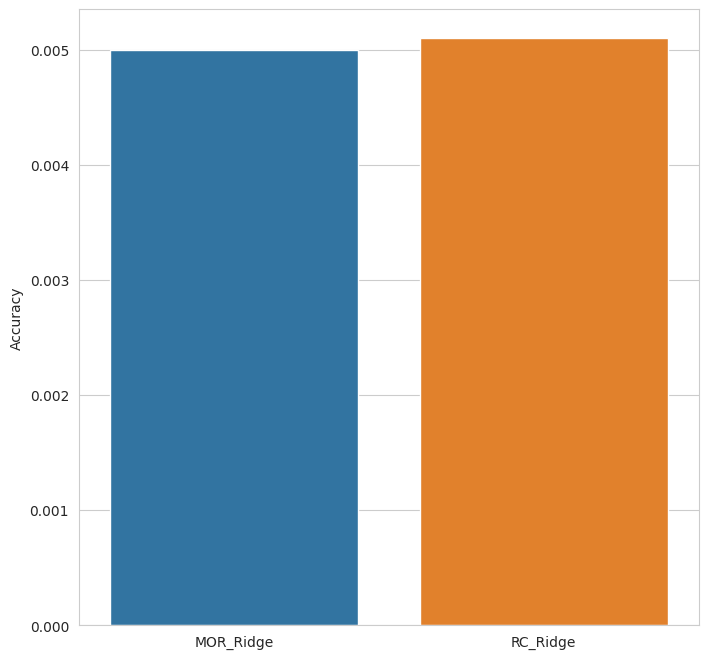

In [307]:
plt.figure(figsize=(8, 8))
plt.ylabel("Accuracy")

sns.barplot(y=list(times.values()), x=list(times.keys()))
plt.show()

**Вывод**: На предложенном датасете обе стратегии показывают практически одинаковые результаты как по времени обучения, так и по точности.